In [1]:
import pandas as pd
import numpy as np
import sys
import os
import itertools
import matplotlib.pyplot as plt
from nltk.corpus import words
from scipy.stats import entropy
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
sys.path.append( '/Users/kgray/Downloads/artemis/src/scripts' )
from generate_entropy_data import generate_shannon_entropy_score
from domain_tools import get_domain_parts
from parse_json import parse_json


In [2]:
random_seed = 355


In [3]:
# Re-using clean/dga datasets from https://github.com/jselvi/phd/tree/master/dga
# Source paper: https://webdiis.unizar.es/~ricardo/files/papers/SRS-ESWA-19.pdf
# Title: Detection of Algorithmically Generated Malicious Domain Names using Masked N-Grams
# Authors: Jose Selvi, Ricardo J. Rodriguez, Emilio Soria
# License: BSD 3-Clause License
# Should look at generating our own or getting a list of registered DGA domains.
# Without registered domains, we can't calculate domain age. However, domain age is 
# highly dependent on when the domain was identifed as malicious and may not be a good
# feature to use.
clean_domains = pd.read_csv('https://raw.githubusercontent.com/jselvi/phd/master/dga/clean-alexa-32k.txt', header=None)
dga_domains = pd.read_csv('https://raw.githubusercontent.com/jselvi/phd/master/dga/dga-bader-32k.txt', header=None)


In [4]:
clean_domains.rename(columns={0: 'domain_name'}, inplace=True)
clean_domains['dga'] = 0
clean_domains.head()


,domain_name,dga
0,google.com,0
1,youtube.com,0
2,facebook.com,0
3,baidu.com,0
4,yahoo.com,0


In [5]:
dga_domains.rename(columns={0: 'domain_name'}, inplace=True)
dga_domains['dga'] = 1
dga_domains.head()


,domain_name,dga
0,rpaiestnessbiophysicalohax.com,1
1,jvfcestnessbiophysicalohax.com,1
2,hhqdestnessbiophysicalohax.com,1
3,flpdestnessbiophysicalohax.com,1
4,rtslestnessbiophysicalohax.com,1


In [6]:
# Combine clean/dga datasets
domains_df = pd.concat([clean_domains, dga_domains]).reset_index().drop(columns='index')


In [7]:
word_list = set(words.words())
word_length_threshold = 3
# Remove words with less than 4 characters
word_list = [x for x in word_list if len(x) > word_length_threshold ]

# Todo: Stop searching when domain becomes all numbers or spaces
# Search for words in domain string. Remove the words from the domain when a match occurs,
# otherwise we could have more word characters in a domain than the length of a string.
# Should consider that shorter words may match first simply due to coming first in
# the dictionary. How can we account for that?
def find_words(domain, word_list, verbose=False):
    word_count = 0
    for word in word_list:
        if word in domain:
            word_count += len(word)
            domain = domain.replace(word, ' ')
            if verbose: print(word + " matched in " + domain)
            if verbose: print("updated domain is now " + domain)
    return(word_count)

In [8]:
def uncommon_letters(string_value):
    # https://en.wikipedia.org/wiki/Letter_frequency
    least_common_letters = ("q", "x", "z", "j", "w")
    letter_count = 0
    for i in range(0,len(string_value)):
        if string_value[i] in least_common_letters:
            letter_count += 1
    return(letter_count)


In [9]:
# Generate features
# Todo: Turn this into a function as well
domains_df['entropy'] = domains_df['domain_name'].apply(lambda x: generate_shannon_entropy_score(x))
domains_df['domain_root'] = domains_df['domain_name'].apply(lambda x: ''.join(get_domain_parts(x)[:2]))
domains_df['length']= domains_df['domain_root'].str.len()
# Consider making this a ratio of count/length (or the implications for leaving it as-is)
domains_df['uncommon_letters'] = domains_df['domain_root'].apply(lambda x: uncommon_letters(x))
domains_df['word_count'] = domains_df['domain_root'].apply(lambda x: find_words(x, word_list))
domains_df['word_ratio'] = domains_df['word_count'] / domains_df['length']
# Todo: Find better solution for domains that have no root, likely due to confusion with
# what a TLD is. For now, drop NaN (only 84 rows).
domains_df.dropna(inplace=True)

In [10]:
# Check for NaN rows
domains_df[domains_df.isna().any(axis=1)]

,domain_name,dga,entropy,domain_root,length,uncommon_letters,word_count,word_ratio


In [11]:
# Reproduce "masked n-gram" idea found in https://webdiis.unizar.es/~ricardo/files/papers/SRS-ESWA-19.pdf.
# Todo: Ensure we're not missing any character types.
# n = number; s = symbol; v = vowel, c = consonant
def mask_string(string_value):
    symbols = ("-")
    vowels = ("a","e","i","o","u")
    masked_domain = []
    for i in range(0,len(string_value)):
        masked_value = ""
        if string_value[i].isnumeric():
            masked_value = "n"
        elif string_value[i] in symbols:  
            masked_value = "s"
        elif string_value[i] in vowels:  
            masked_value = "v"
        else:  
            masked_value = "c"
        masked_domain.append(masked_value)
    return ''.join(masked_domain)


In [12]:
# Create all possible combinations of masked n-gram values for features.
ngram_size=4
masked_ngram_values = ['n', 's', 'v', 'c']
ngram_combinations = [''.join(i) for i in itertools.product(masked_ngram_values, repeat = ngram_size)]


In [13]:
domains_df['masked_domain'] = domains_df['domain_root'].apply(lambda x: mask_string(x))
domains_df['masked_ngrams'] = domains_df['masked_domain'].apply(lambda x: [x[i:i+ngram_size] for i in range(len(x)-ngram_size+1)])

# One-hot encode masked ngrams and combine with other features. Will not make sparse.
# Todo: Make this a function that returns the one-hot encoded dataframe, since we do this same thing below.
mlb = MultiLabelBinarizer()
domains_df = domains_df.join(pd.DataFrame(mlb.fit_transform(domains_df.pop('masked_ngrams')),
                            index=domains_df.index, columns=mlb.classes_))


In [14]:
# Add in missing features to make sure this is compatible with the model created below.
missing_features = list(set(ngram_combinations) - set(mlb.classes_))
temp_domains_df = pd.DataFrame(index=domains_df.index, columns=missing_features)
temp_domains_df = temp_domains_df.replace(np.nan, 0)

domains_df = domains_df.join(temp_domains_df)


In [15]:
# Prepare domain for modeling 
domains_df = domains_df.set_index('domain_name').drop(columns=['domain_root', 'masked_domain'])


In [16]:
domains_df


,dga,entropy,length,uncommon_letters,word_count,word_ratio,cccc,cccn,cccs,cccv,...,ssns,ncns,snsv,ssnc,sssn,nncs,nnsv,svvv,vvsn,nsnc
domain_name,,,,,,,,,,,,,,,,,,,,,
google.com,0,2.646439,6,0,4,0.666667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
youtube.com,0,3.095795,7,0,4,0.571429,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
facebook.com,0,3.022055,8,0,8,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
baidu.com,0,3.169925,5,0,0,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yahoo.com,0,2.641604,5,0,5,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
agituaf.eu,1,2.921928,7,0,0,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hyhzgol.cc,1,2.921928,7,1,0,0.000000,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
nffjshqk.eu,1,3.277613,8,2,0,0.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
y_col = 'dga'
y = domains_df[y_col]
X = domains_df[domains_df.columns.drop(y_col)]
#model = RandomForestClassifier(random_state=random_seed)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=random_seed)
#n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
model = RandomForestClassifier(random_state=random_seed)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)

Accuracy: 0.944


Feature: 0, Score: 0.11787
Feature: 1, Score: 0.13765
Feature: 2, Score: 0.11885
Feature: 3, Score: 0.09462
Feature: 4, Score: 0.13429
Feature: 5, Score: 0.14622
Feature: 6, Score: 0.00617
Feature: 7, Score: 0.00024
Feature: 8, Score: 0.04538
Feature: 9, Score: 0.00360
Feature: 10, Score: 0.00105
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00037
Feature: 13, Score: 0.00076
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00012
Feature: 16, Score: 0.00013
Feature: 17, Score: 0.00953
Feature: 18, Score: 0.00266
Feature: 19, Score: 0.00023
Feature: 20, Score: 0.00829
Feature: 21, Score: 0.00408
Feature: 22, Score: 0.00084
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00065
Feature: 25, Score: 0.00173
Feature: 26, Score: 0.00034
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00094
Feature: 29, Score: 0.00001
Feature: 30, Score: 0.00060
Feature: 31, Score: 0.00016
Feature: 32, Score: 0.00003
Feature: 33, Score: 0.00028
Feature: 34, Score: 0.00002
Feature: 35, Score: 0.00001
Fe

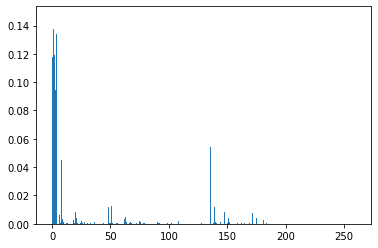

In [20]:
importance = model.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [21]:
# Load our domain data
data_dir = '../data/raw/'

# Gather a list of data files
data_file_list = []
for filename in os.listdir(data_dir):
    if filename.startswith("benign") | filename.startswith("malicious"):
        f = os.path.join(data_dir, filename)
        if os.path.isfile(f):
            data_file_list.append((f, filename))

In [22]:
# Load data into memory via dict referenced by filename
data_file_dict = {}
for data_file in data_file_list:
    with open(data_file[0]) as f:
        data = f.read()
        
        data_list = []
        while True:
            obj, remaining = parse_json(data)
            data_list.append(obj)
            data = remaining
            if not remaining.strip():
                break
        data_file_dict[data_file[1]] = data_list

In [23]:
# Create dataframes for our benign and malicious data
benign_domain_list = []
for benign_domain_whois in data_file_dict['benign_whois_data.txt']:
    benign_domain_list.append(list(benign_domain_whois.keys())[0])
benign_domain_without_tld_dict = {}
for benign_domain_name in benign_domain_list:
    domain_parts = get_domain_parts(benign_domain_name)[:2]
    benign_domain_without_tld_dict[benign_domain_name] = [''.join(domain_parts[:2])]
benign_domain_df = pd.DataFrame.from_dict(benign_domain_without_tld_dict).T.rename(columns={0: 'domain_root'})
benign_domain_df['malicious'] = 0

malicious_domain_list = []
for malicious_domain_whois in data_file_dict['malicious_whois_data.txt']:
    malicious_domain_list.append(list(malicious_domain_whois.keys())[0])
malicious_domain_without_tld_dict = {}
for malicious_domain_name in malicious_domain_list:
    domain_parts = get_domain_parts(malicious_domain_name)[:2]
    malicious_domain_without_tld_dict[malicious_domain_name] = [''.join(domain_parts[:2])]
malicious_domain_df = pd.DataFrame.from_dict(malicious_domain_without_tld_dict).T.rename(columns={0: 'domain_root'})
malicious_domain_df['malicious'] = 1

# Combine DataFrames
artemis_domains_df = pd.concat([benign_domain_df, malicious_domain_df])
artemis_domains_df = artemis_domains_df.reset_index().rename(columns={'index': 'domain_name'})

In [24]:
# Generate features
artemis_domains_df['entropy'] = artemis_domains_df['domain_name'].apply(lambda x: generate_shannon_entropy_score(x))
artemis_domains_df['domain_root'] = artemis_domains_df['domain_name'].apply(lambda x: ''.join(get_domain_parts(x)[:2]))
artemis_domains_df['length']= artemis_domains_df['domain_root'].str.len()
artemis_domains_df['uncommon_letters'] = artemis_domains_df['domain_root'].apply(lambda x: uncommon_letters(x))
artemis_domains_df['word_count'] = artemis_domains_df['domain_root'].apply(lambda x: find_words(x, word_list))
artemis_domains_df['word_ratio'] = artemis_domains_df['word_count'] / artemis_domains_df['length']
# Todo: Find better solution for domains that have no root, likely due to confusion with
# what a TLD is. For now, drop NaN.
artemis_domains_df.dropna(inplace=True)

In [25]:
plot_features = ['entropy', 'length', 'uncommon_letters', 'word_ratio', 'malicious']
artemis_domains_df.groupby('malicious')[plot_features].describe()


entropy                                                              \
            count      mean       std       min       25%       50%       75%   
malicious                                                                       
0          3610.0  3.070723  0.373898  1.500000  2.807355  3.095795  3.366091   
1          2394.0  3.475336  0.335282  1.770951  3.251629  3.456565  3.725481   

                     length             ... word_ratio      malicious       \
                max   count       mean  ...        75%  max     count mean   
malicious                               ...                                  
0          4.053509  3610.0   7.577285  ...   0.800000  1.0    3610.0  0.0   
1          4.496143  2394.0  12.997494  ...   0.533333  1.0    2394.0  1.0   

                                         
           std  min  25%  50%  75%  max  
malicious                                
0          0.0  0.0  0.0  0.0  0.0  0.0  
1          0.0  1.0  1.0  1.0  1.0  1.0  

[2 rows x 40 columns]

/var/folders/zk/_l6jn98j1ws6ndxrzcw2dh4m0000gn/T/ipykernel_40664/394586290.py:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  boxplot_dict = artemis_domains_df[plot_features].boxplot(


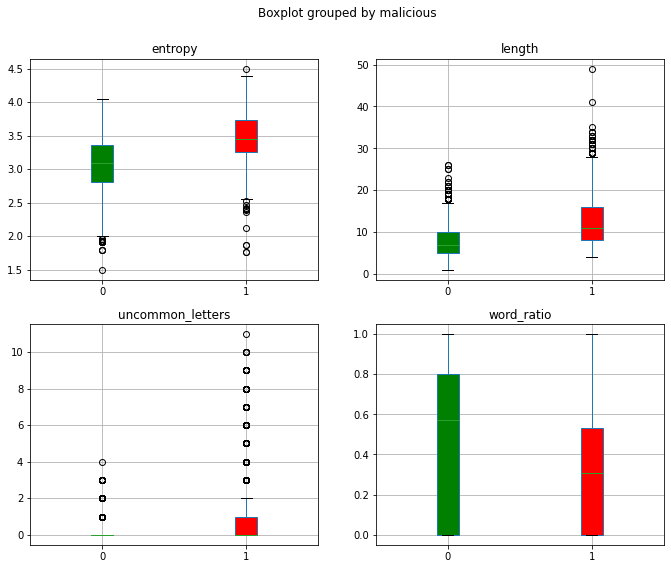

In [26]:
plt.rcParams["figure.figsize"] = [11, 9]

fig, axes = plt.subplots(2,2,sharex=False,sharey=False)

boxplot_dict = artemis_domains_df[plot_features].boxplot(
    by="malicious", ax=axes, figsize=(6,4),
    return_type='both',
    patch_artist = True
)

colors = ['g', 'r']
for row_key, (ax,row) in boxplot_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
        
plt.show()

In [27]:
artemis_domains_df['masked_domain'] = artemis_domains_df['domain_root'].apply(lambda x: mask_string(x))
artemis_domains_df['masked_ngrams'] = artemis_domains_df['masked_domain'].apply(lambda x: [x[i:i+ngram_size] for i in range(len(x)-ngram_size+1)])

# One-hot encode masked ngrams and combine with other features. Will not make sparse.
mlb = MultiLabelBinarizer()
artemis_domains_df = artemis_domains_df.join(pd.DataFrame(mlb.fit_transform(artemis_domains_df.pop('masked_ngrams')),
                            index=artemis_domains_df.index, columns=mlb.classes_))


In [28]:
# Add in missing features to make sure this is compatible with the model created above.
missing_features = list(set(ngram_combinations) - set(mlb.classes_))
temp_artemis_df = pd.DataFrame(index=artemis_domains_df.index, columns=missing_features)
temp_artemis_df = temp_artemis_df.replace(np.nan, 0)

artemis_domains_df = artemis_domains_df.join(temp_artemis_df)


In [29]:
# Prepare domain for modeling 
artemis_domains_df = artemis_domains_df.set_index('domain_name').drop(columns=['domain_root', 'masked_domain'])

# Reorder features so they match domains_df (otherwise sklearn will complain)
reordered_columns = domains_df.columns
reordered_columns = [item.replace('dga', 'malicious') for item in reordered_columns]
artemis_domains_df = artemis_domains_df.reindex(reordered_columns, axis=1)

In [30]:
artemis_domains_df

,malicious,entropy,length,uncommon_letters,word_count,word_ratio,cccc,cccn,cccs,cccv,...,ssns,ncns,snsv,ssnc,sssn,nncs,nnsv,svvv,vvsn,nsnc
domain_name,,,,,,,,,,,,,,,,,,,,,
google.com,0,2.646439,6,0,4,0.666667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
facebook.com,0,3.022055,8,0,8,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
youtube.com,0,3.095795,7,0,4,0.571429,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
twitter.com,0,3.027169,7,1,4,0.571429,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
instagram.com,0,3.392747,9,0,4,0.444444,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ewakyc72.top,1,3.584963,8,1,4,0.500000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ewazqx71.top,1,3.584963,8,4,0,0.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
rebornx.duckdns.org,1,3.576618,14,1,8,0.571429,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Predict DGA on legitimate domains (number of DGA predictions should be low)
X_benign = artemis_domains_df[artemis_domains_df['malicious'] == 0].drop(
                                columns=['malicious'])

In [32]:
# Make predictions on benign domains
y_benign = model.predict(X_benign)

In [33]:
count = np.count_nonzero(y_benign == 1)
print("Benign domains predicted as DGA: " + str(round(count / len(y_benign) * 100, 2)) + "%")

Benign domains predicted as DGA: 2.13%


In [34]:
# Predict DGA on malicious domains (number of DGA predictions should be higher)
X_malicious = artemis_domains_df[artemis_domains_df['malicious'] == 1].drop(
                                columns=['malicious'])

In [35]:
# Make predictions on benign domains
y_malicious = model.predict(X_malicious)

In [36]:
count = np.count_nonzero(y_malicious == 1)
print("Malicious domains predicted as DGA: " + str(round(count / len(y_malicious) * 100, 2)) + "%")

Malicious domains predicted as DGA: 36.47%


In [37]:
# Todo: Find a more elegant way to do this.
# Remove DGA domains from dataframe.
malicious_temp_df = artemis_domains_df[artemis_domains_df['malicious'] == 1].copy()
malicious_temp_df['dga'] = y_malicious
malicious_dga_domain_list = list(malicious_temp_df[malicious_temp_df['dga'] == 1].index)
malicious_temp_df.drop(malicious_temp_df[malicious_temp_df['dga'] == 1].index, inplace=True)
artemis_domains_df.drop(artemis_domains_df[artemis_domains_df['malicious'] == 1].index, inplace=True)
artemis_domains_df = pd.concat([artemis_domains_df, malicious_temp_df])
malicious_nondga_domain_list = list(artemis_domains_df[artemis_domains_df['malicious'] == 1].index)

In [38]:
malicious_dga_domain_list

['crmweb.info',
 'artanddesign.one',
 'autodiscover.karlamejia.com',
 'unpszx0ql5.cloud',
 'rt7j4qoiqh.cloud',
 'xp0tztbd3s.cloud',
 'yke6jpq69x.cloud',
 'heexcnqklq.shop',
 'l4uxr5s2yq.online',
 'lih2wbii62.shop',
 'ltpyi8i70o.shop',
 'p2jnahbccw.shop',
 'qau6z4582u.shop',
 'r53z7jfphl.online',
 'rofbiqr0wx.online',
 'veermckenzie483.website',
 'zackaryfritz357.website',
 'matasmcmanus3256.website',
 'nancydouglas67.website',
 'finleymcghee458.website',
 'kaitlynmcneil275.website',
 'ayishajimenez232.top',
 'brysoncash848.website',
 'cataleyatrejo863.website',
 'charlieklein7547.website',
 'eilidhmcarthu458r.website',
 'ajwamccall426.website',
 'alessandroknights3434.top',
 'zmi692fchugg4.world',
 'hn6dga8vkkm9ah.world',
 'hqaxkbbma05u48.agency',
 'itx02gler3uk5.digital',
 'mng7wu9tx22isva.digital',
 'pa49ed5cxjrdj.digital',
 'rwaehpjqfyyvfmam7.today',
 'sj04xb2nh59mg5.agency',
 'v1xmw5x3phqc.digital',
 'x1zu4ksval1hjh5.today',
 'yxjukwts3tt.today',
 '4g796aiv4kj1.world',
 '5pneuovxi2

In [39]:
malicious_nondga_domain_list

['reseptors.com',
 'contentcdns.net',
 'izocab.com',
 'eleccom.shop',
 'accessunited-bank.com',
 'strawberry.kids-singer.net',
 'ledcaopingdeng.com',
 'krezol-group.com',
 'badgoodreason.com',
 'cooldogblunts.com',
 'coolbearblunts.com',
 'betleverdoom.quest',
 'blutimeddoom.quest',
 'damleverdstar.cfd',
 'dingsteddoom.quest',
 'flametradoom.quest',
 'flamsgindstar.cfd',
 'navegandostar.cfd',
 'neitelandstar.cfd',
 'aeringwebstar.cfd',
 'anintenddoom.quest',
 'irsgetwell.net',
 'solramos2643.website',
 'tainemerritt6538.website',
 'mcauleysampson123.website',
 'mohammodhealy32.website',
 'nathaliechang1243.website',
 'rayagreenaway5483.website',
 'robbiequintero23.website',
 'roryblaese13.website',
 'serenalaingw6.website',
 'skylarkelley215.website',
 'enyaallan7604.website',
 'francescarobertson842.website',
 'franciscomarshall66.website',
 'gutogaines456.website',
 'hughmackay66479.website',
 'kayneedge436.website',
 'khadeejahdunn235.website',
 'louisadickens483.website',
 'ambabar

/var/folders/zk/_l6jn98j1ws6ndxrzcw2dh4m0000gn/T/ipykernel_40664/1868582310.py:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  boxplot_dict = artemis_domains_df[plot_features].boxplot(


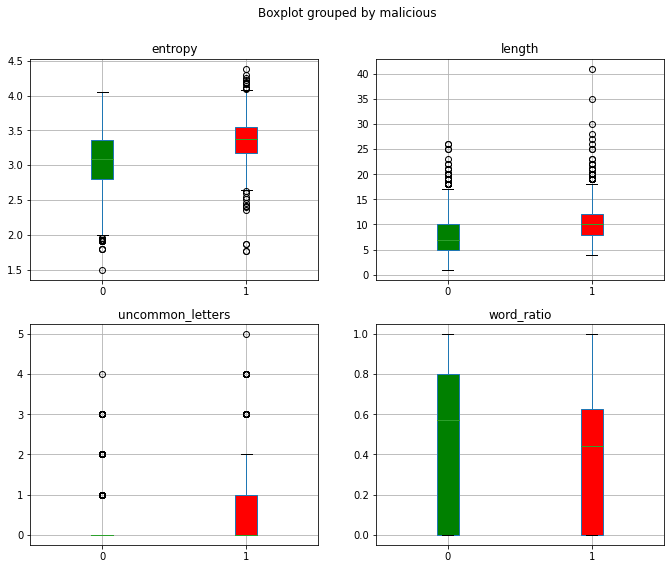

In [40]:
fig, axes = plt.subplots(2,2,sharex=False,sharey=False)

boxplot_dict = artemis_domains_df[plot_features].boxplot(
    by="malicious", ax=axes, figsize=(6,4),
    return_type='both',
    patch_artist = True
)

colors = ['g', 'r']
for row_key, (ax,row) in boxplot_dict.iteritems():
    ax.set_xlabel('')
    for i,box in enumerate(row['boxes']):
        box.set_facecolor(colors[i])
plt.show()

In [41]:
artemis_domains_df.groupby('malicious')[plot_features].describe()

entropy                                                              \
            count      mean       std       min       25%       50%       75%   
malicious                                                                       
0          3610.0  3.070723  0.373898  1.500000  2.807355  3.095795  3.366091   
1          1521.0  3.356877  0.294719  1.770951  3.180833  3.375000  3.546594   

                     length             ... word_ratio      malicious       \
                max   count       mean  ...        75%  max     count mean   
malicious                               ...                                  
0          4.053509  3610.0   7.577285  ...   0.800000  1.0    3610.0  0.0   
1          4.384517  1521.0  10.534517  ...   0.628571  1.0    1521.0  1.0   

                                         
           std  min  25%  50%  75%  max  
malicious                                
0          0.0  0.0  0.0  0.0  0.0  0.0  
1          0.0  1.0  1.0  1.0  1.0  1.0  

[2 rows x 40 columns]